In [15]:
import pandas as pd
import numpy as np
from pypfopt import EfficientFrontier, risk_models, expected_returns
import matplotlib.pyplot as plt

In [16]:
# Load data
data = pd.read_csv('../data/financial_data_clean.csv', index_col=0, parse_dates=True)
adj_close = data[['TSLA_Adj Close', 'BND_Adj Close', 'SPY_Adj Close']].asfreq('B').fillna(method='ffill')

In [17]:
# Calculate daily returns
daily_returns = adj_close.pct_change().dropna()

# Debug: Check daily returns
print("Daily Returns Summary:")
print(daily_returns.describe())

# Expected returns
# TSLA: Use 6-month forecast from Task 3 ($319.28)
last_tsla_price = adj_close['TSLA_Adj Close'][-1]
tsla_6m_return = (319.28 - last_tsla_price) / last_tsla_price  # 6-month return
tsla_annual_return = ((1 + tsla_6m_return) ** (252 / 126) - 1)  # Annualize

# BND and SPY: Use historical mean daily returns, annualized
mean_daily_returns = daily_returns.mean()
bnd_annual_return = (1 + mean_daily_returns['BND_Adj Close']) ** 252 - 1
spy_annual_return = (1 + mean_daily_returns['SPY_Adj Close']) ** 252 - 1

# Expected returns vector
expected_returns_annual = pd.Series({
    'TSLA_Adj Close': tsla_annual_return,
    'BND_Adj Close': bnd_annual_return,
    'SPY_Adj Close': spy_annual_return
})
print("\nExpected Annual Returns:")
print(expected_returns_annual)

Daily Returns Summary:
       TSLA_Adj Close  BND_Adj Close  SPY_Adj Close
count     2631.000000    2631.000000    2631.000000
mean         0.001761       0.000075       0.000554
std          0.036593       0.003395       0.011277
min         -0.210628      -0.054384      -0.109424
25%         -0.016371      -0.001437      -0.003428
50%          0.000000       0.000000       0.000464
75%          0.018971       0.001708       0.005761
max          0.226900       0.042200       0.105019

Expected Annual Returns:
TSLA_Adj Close    0.001505
BND_Adj Close     0.019055
SPY_Adj Close     0.149659
dtype: float64


In [18]:
# Covariance matrix (annualized)
# Ensure daily_returns are in decimal form
cov_matrix = risk_models.sample_cov(daily_returns, frequency=252)
print("\nCovariance Matrix:")
print(cov_matrix)

# Debug: Check annualized standard deviations
print("\nAnnualized Standard Deviations:")
print(np.sqrt(np.diag(cov_matrix)))

# Efficient Frontier
ef = EfficientFrontier(expected_returns_annual, cov_matrix)
ef_max_sharpe = ef.max_sharpe(risk_free_rate=0.04)
max_sharpe_weights = ef.clean_weights()
max_sharpe_perf = ef.portfolio_performance(verbose=True, risk_free_rate=0.04)

ef = EfficientFrontier(expected_returns_annual, cov_matrix)
ef_min_vol = ef.min_volatility()
min_vol_weights = ef.clean_weights()
min_vol_perf = ef.portfolio_performance(verbose=True, risk_free_rate=0.04)

# Get maximum possible return
ef = EfficientFrontier(expected_returns_annual, cov_matrix)
max_return = ef._max_return()
print(f"\nMaximum Possible Return: {max_return}")

# Generate Efficient Frontier points
returns = np.linspace(min_vol_perf[0], min(max_sharpe_perf[0], max_return * 0.99), 50)
ef_points = []
for ret in returns:
    try:
        ef = EfficientFrontier(expected_returns_annual, cov_matrix)
        ef.efficient_return(ret)
        ef_points.append(ef.portfolio_performance(risk_free_rate=0.04))
    except Exception as e:
        print(f"Failed for target return {ret}: {e}")
        continue


Covariance Matrix:
                TSLA_Adj Close  BND_Adj Close  SPY_Adj Close
TSLA_Adj Close   106980.880907     240.966629     -43.203480
BND_Adj Close       240.966629    6727.430710     350.903457
SPY_Adj Close       -43.203480     350.903457   57893.678180

Annualized Standard Deviations:
[327.07931898  82.0209163  240.61105166]
Expected annual return: 15.0%
Annual volatility: 24061.1%
Sharpe Ratio: 0.00
Expected annual return: 3.1%
Annual volatility: 7605.6%
Sharpe Ratio: -0.00

Maximum Possible Return: 0.14965937796979775


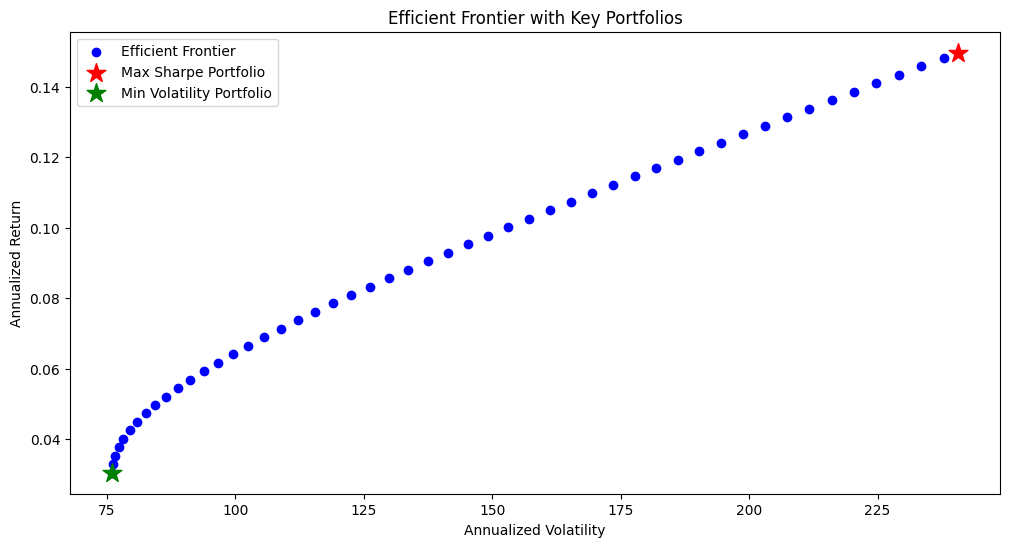

In [19]:
# Plot Efficient Frontier
plt.figure(figsize=(12, 6))
plt.scatter([p[1] for p in ef_points], [p[0] for p in ef_points], c='blue', label='Efficient Frontier')
plt.scatter(max_sharpe_perf[1], max_sharpe_perf[0], c='red', marker='*', s=200, label='Max Sharpe Portfolio')
plt.scatter(min_vol_perf[1], min_vol_perf[0], c='green', marker='*', s=200, label='Min Volatility Portfolio')
plt.xlabel('Annualized Volatility')
plt.ylabel('Annualized Return')
plt.title('Efficient Frontier with Key Portfolios')
plt.legend()
plt.show()
plt.savefig('../plots/efficient_frontier.png')
plt.close()

In [20]:
# Save portfolio metrics
portfolio_metrics = pd.DataFrame({
    'Portfolio': ['Max Sharpe', 'Min Volatility'],
    'TSLA Weight': [max_sharpe_weights['TSLA_Adj Close'], min_vol_weights['TSLA_Adj Close']],
    'BND Weight': [max_sharpe_weights['BND_Adj Close'], min_vol_weights['BND_Adj Close']],
    'SPY Weight': [max_sharpe_weights['SPY_Adj Close'], min_vol_weights['SPY_Adj Close']],
    'Expected Return': [max_sharpe_perf[0], min_vol_perf[0]],
    'Volatility': [max_sharpe_perf[1], min_vol_perf[1]],
    'Sharpe Ratio': [max_sharpe_perf[2], min_vol_perf[2]]
})
portfolio_metrics.to_csv('../data/portfolio_metrics.csv', index=False)
print("\nPortfolio Metrics:")
print(portfolio_metrics)


Portfolio Metrics:
        Portfolio  TSLA Weight  BND Weight  SPY Weight  Expected Return  \
0      Max Sharpe      0.00000     0.00000     1.00000         0.149659   
1  Min Volatility      0.05219     0.85303     0.09478         0.030519   

   Volatility  Sharpe Ratio  
0  240.611052      0.000456  
1   76.056033     -0.000125  
